In [2]:
import numpy as np
import random

In [3]:
# Quadratic cost function
class QuadraticCost():
    @staticmethod
    def fn(a, y):
        """
        Compute cost for an output and its corresponding desired output
        """
        return 0.5 * np.linalg.norm(a-y)**2
        
    @staticmethod
    def delta(z, a, y):
        """
        Output layer error
        """
        return sigmoid_prime(z) * (a - y)

In [4]:
# Cross-entropy cost function
class CrossEntropyCost():
    @staticmethod
    def fn(a, y):
        """
        Compute cost for an output and its corresponding desired output
        """
        return np.sum(-y * np.log(a) - (1 - y) * np.log(1 - a))
    
    @staticmethod
    def delta(z, a, y):
        """
        Outpu layer error
        """
        return a - y

In [9]:
class Network():
    """
    The neural network class
    """
    
    def __init__(self, sizes, cost=CrossEntropyCost):
        """
        sizes: an array containing the number of neuons in each layer, layer 0 is the input layer
        num_layer: number of layers in the network
        biases: randomly initialized array containing column vector of biases for each layer
        weights: randomly initialized array containig m(l-1) * m(l) weight matrix for each layer
        """
        self.num_layer = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[1:], sizes[:-1])]
        self.cost = cost
    
    def feedforward(self, a):
        """
        Feed forward the network and get zs and activations
        Activations in the final layer is the output
        """
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w.T, a) + b)
        return a
    
    def sgd(self, training_data, epochs, mini_batch_size, alpha, test_data):
        """
        Mini-batch stocastic gradient descent
        training_data: input training data
        epochs: number of times to run the whole training data
        mini_batch_size: how many training examples in a mini batch
        alpha: learning rate
        test_data: if provided, evaluate performance after each epoch
        """
        test_data = list(test_data)
        n_test = len(test_data)
            
        training_data = list(training_data)
        n = len(training_data)
        
        training_cost, training_accuracy = [], []
        test_cost, test_accuracy = [], []
        
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k + mini_batch_size] for k in range(0, n, mini_batch_size)]
            
            for mini_batch in mini_batches:
                self.update_network(mini_batch, alpha)
            
            training_cost.append(self.get_total_cost(training_data))
            training_accuracy.append(self.evaluate(training_data, True))
            test_cost.append(self.get_total_cost(test_data))
            test_accuracy.append(self.evaluate(test_data, False))
     
        print("Training completed")
        return training_cost, training_accuracy, test_cost, test_accuracy
    
    def update_network(self, mini_batch, alpha):
        """
        Update the weights and biases of the network
        mini_batch: mini batch containg training examples
        alpha: learning rate
        """
        batch_deriv_b = [np.zeros(b.shape) for b in self.biases]
        batch_deriv_w = [np.zeros(w.shape) for w in self.weights]
        
        # Get the sum of derivatives of the mini batch
        for x, y in mini_batch:
            this_deriv_w, this_deriv_b = self.backprop(x, y)
            batch_deriv_b = [nb + dnb for nb, dnb in zip(batch_deriv_b, this_deriv_b)]
            batch_deriv_w = [nw + dnw for nw, dnw in zip(batch_deriv_w, this_deriv_w)]
        
        # Update weights and biases
        self.weights = [w - (alpha / len(mini_batch)) * nw for w, nw in zip(self.weights, batch_deriv_w)]
        self.biases = [b - (alpha / len(mini_batch)) * nb for b, nb in zip(self.biases, batch_deriv_b)]
        
    def backprop(self, x, y):
        """
        Backpropagate to calculate cost function gradients for each training example
        x, y: single input training example
        """
        deriv_b = [np.zeros(b.shape) for b in self.biases]
        deriv_w = [np.zeros(w.shape) for w in self.weights]
        
        # Feedforward to calculate zs and activations
        activations = [x]
        zs = []
        
        for w, b in zip(self.weights, self.biases):
            zs.append(np.dot(w.T, activations[-1]) + b)
            activations.append(sigmoid(zs[-1]))
        
        # Backward pass
        # Output layer delta and gradients
        delta = self.cost.delta(zs[-1], activations[-1], y)
        deriv_b[-1] = delta
        deriv_w[-1] = np.dot(activations[-2], delta.T)
        
        # Previous layers
        for l in range(2, self.num_layer):
            z = zs[-l]
            delta = np.dot(self.weights[-l + 1], delta) * sigmoid_prime(z)
            deriv_b[-l] = delta
            deriv_w[-l] = np.dot(activations[-l - 1], delta.T)
            
        return (deriv_w, deriv_b)
    
    def get_total_cost(self, data):
        """
        Compute total cost using the computed weights and biases
        """
        cost = 0
        for x, y in data:
            a = self.feedforward(x)
            cost += self.cost.fn(a, y) / len(data)
        return cost
        
    def evaluate(self, data, convert):
        """
        Return the number of correctly predicted results
        data: dataset to evaluate
        convert: True for training data, False for test data
        """
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]

        result_accuracy = sum(int(x == y) for (x, y) in results) / len(data)
        return result_accuracy
    
def sigmoid(x):
    """The sigmoid function"""
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x):
    """Derivative of the sigmoid function"""
    return sigmoid(x) * (1 - sigmoid(x))

In [14]:
# Test
# Using cross-entropy cost function
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
epochs = 300

net = Network([784, 30, 10])
training_cost, training_accuracy, test_cost, test_accuracy = net.sgd(training_data, epochs, 10, 2.0, test_data=test_data)

Training completed


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

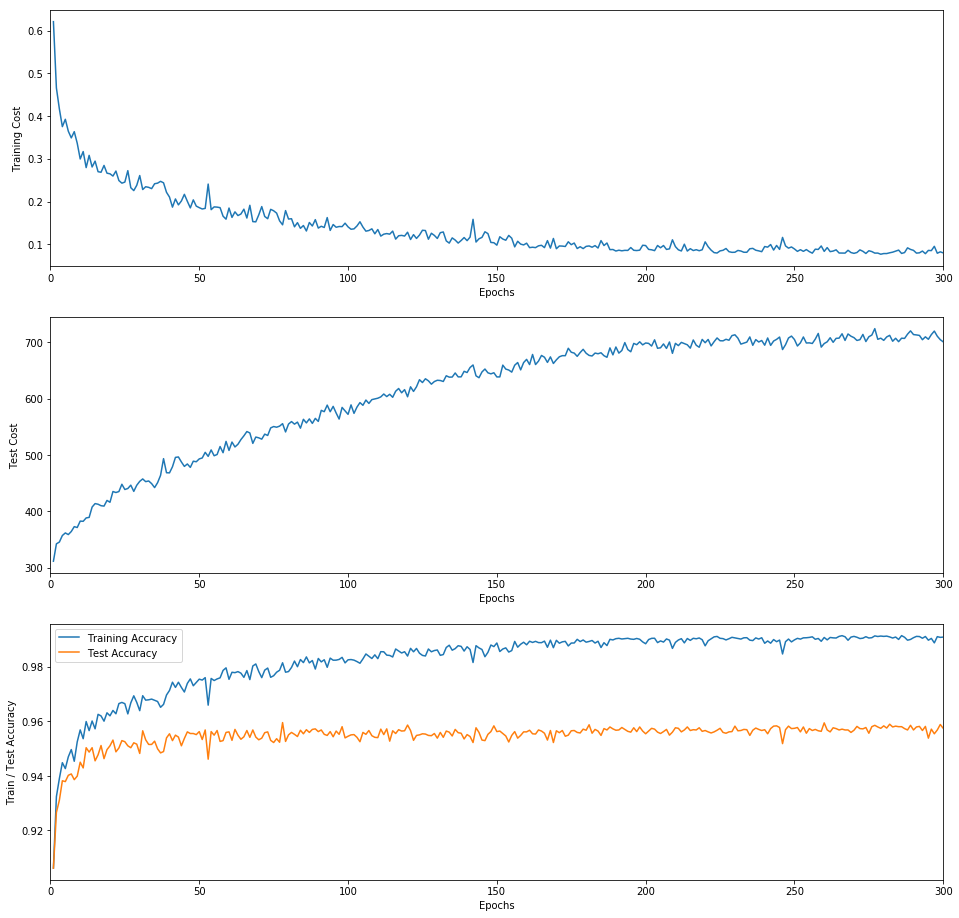

In [16]:
canvas = plt.figure(figsize=(16, 16))
sp1 = canvas.add_subplot(311)
sp2 = canvas.add_subplot(312)
sp3 = canvas.add_subplot(313)

sp1.set_xlim(0, epochs)
sp1.plot([i for i in range(1, epochs + 1)], training_cost)
sp1.set_xlabel('Epochs')
sp1.set_ylabel('Training Cost')

sp2.set_xlim(0, epochs)
sp2.plot([i for i in range(1, epochs + 1)], test_cost)
sp2.set_xlabel('Epochs')
sp2.set_ylabel('Test Cost')

sp3.set_xlim(0, epochs)
sp3.plot([i for i in range(1, epochs + 1)], training_accuracy, label='Training Accuracy')
sp3.plot([i for i in range(1, epochs + 1)], test_accuracy, label='Test Accuracy')
sp3.set_xlabel('Epochs')
sp3.set_ylabel('Train / Test Accuracy')
sp3.legend()

plt.show()